Minecraft Research Server - DSCI 100
Giles Lo

In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)

library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 6)

set.seed(2025) # DO NOT REMOVE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Introduction

Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Strategy Overview

Reading File

In [2]:
# Run this cell to read files
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

players <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA", played_hours < 100)
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


Exploring the Data

First, lets remove all the rows containing "NA" from the data.

In [3]:
sessions_clean <- sessions |>
    select(start_time, end_time) |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ") |>
    filter(!is.na(start_date), !is.na(end_date), !is.na(start_time), !is.na(end_time))
sessions_clean

start_date,start_time,end_date,end_time
<chr>,<chr>,<chr>,<chr>
30/06/2024,18:12,30/06/2024,18:24
17/06/2024,23:33,17/06/2024,23:46
25/07/2024,17:34,25/07/2024,17:57
⋮,⋮,⋮,⋮
28/07/2024,15:36,28/07/2024,15:57
25/07/2024,06:15,25/07/2024,06:22
20/05/2024,02:26,20/05/2024,02:45


Let's draw a single sample of size 40 from the population and visualize it:

In [ ]:
one_sample <- can_seniors |> 
    rep_sample_n(40) |> 
    ungroup() |> # ungroup the data frame 
    select(age) # drop the replicate column 
one_sample

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)
# run this cell 
one_sample_dist <- ggplot(one_sample, aes(age)) + 
    geom_histogram(binwidth = 1) +
    xlab("Age (years)") +
    ggtitle("Distribution of one sample") +
    theme(text = element_text(size = 20))
one_sample_dist

In [ ]:
one_sample_estimates <- one_sample |>
    summarize(mean = mean(age))
one_sample_estimates

Bootstraping Data

In [73]:
boot_sessions_100 <- sessions_clean |>
    rep_sample_n(size = 100, replace = TRUE, reps = 10)
head(boot_sessions)

replicate,start_date,start_time,end_date,end_time
<int>,<chr>,<chr>,<chr>,<chr>
1,21/08/2024,02:50,21/08/2024,04:46
1,25/08/2024,01:54,25/08/2024,02:05
1,12/05/2024,15:37,12/05/2024,15:53
1,25/07/2024,06:56,25/07/2024,07:00
1,01/05/2024,02:28,01/05/2024,02:41
1,28/04/2024,04:11,28/04/2024,04:42


In [74]:
sessions_month_100 <- boot_sessions_100 |>
    mutate(start_date = as.Date(start_date, format = "%d/%m/%Y"), end_date = as.Date(end_date, format = "%d/%m/%Y")) |>
    mutate(date = map2(start_date, end_date, ~seq(.x, .y, by = "day"))) |>
    unnest(date) |>
    mutate(month = format(date, "%m")) |>
    count(month) |>
    rename(count = n)
sessions_month_100

replicate,month,count
<int>,<chr>,<int>
1,04,11
1,05,24
1,06,31
⋮,⋮,⋮
10,07,22
10,08,21
10,09,9


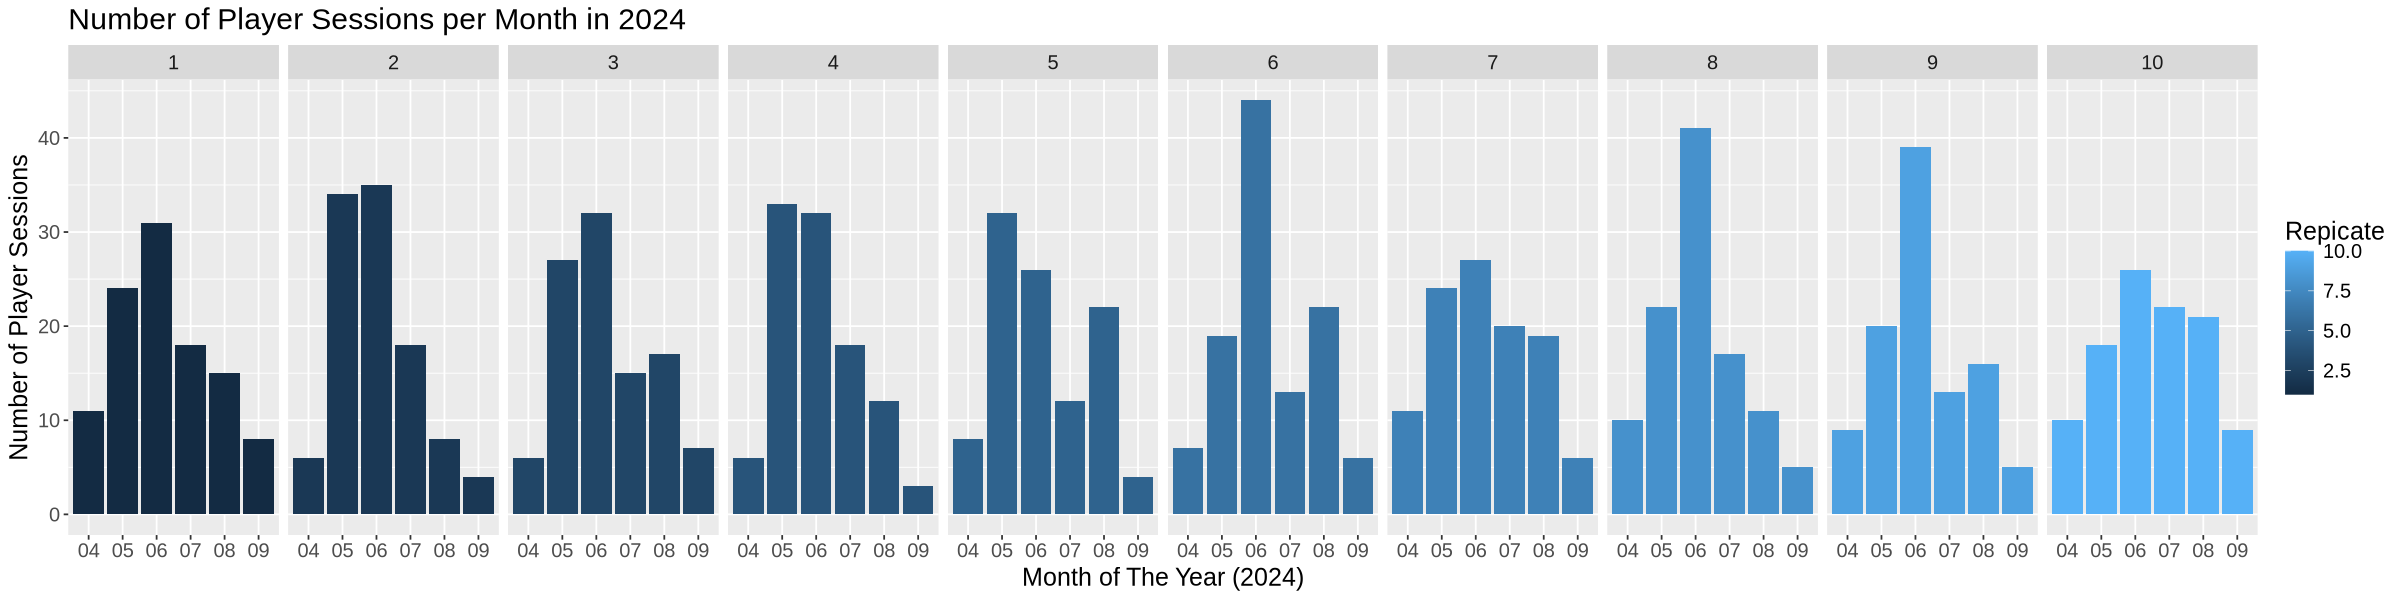

In [75]:
options(repr.plot.width = 20, repr.plot.height = 5)

sessions_plot_100 <- sessions_month_100 |>
    ggplot(aes(x = month, y = count, fill = replicate)) + 
    geom_col() +
    facet_grid(cols = vars(replicate)) + 
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024",
         fill = "Repicate") +
    theme(text = element_text(size = 15))

sessions_plot_100

Analysis of Plot

We see that...

Now let's see what the greatest average players for the months are for many reps

replicate,month,count
<int>,<chr>,<int>
1,04,10
1,05,22
1,06,31
⋮,⋮,⋮
300,07,18
300,08,18
300,09,7


month,count
<chr>,<dbl>
04,10
05,24
06,31
07,19
08,16
09,7


[1] 7

We now have the

In [89]:
sessions_month_max <- sessions_month_average|>
    arrange(count) |>
    slice(1) |>
    pull()
sessions_month_max

[1] 7

We see that on average, there are a greater total number of player sessions in June.

Lets now visualize the av

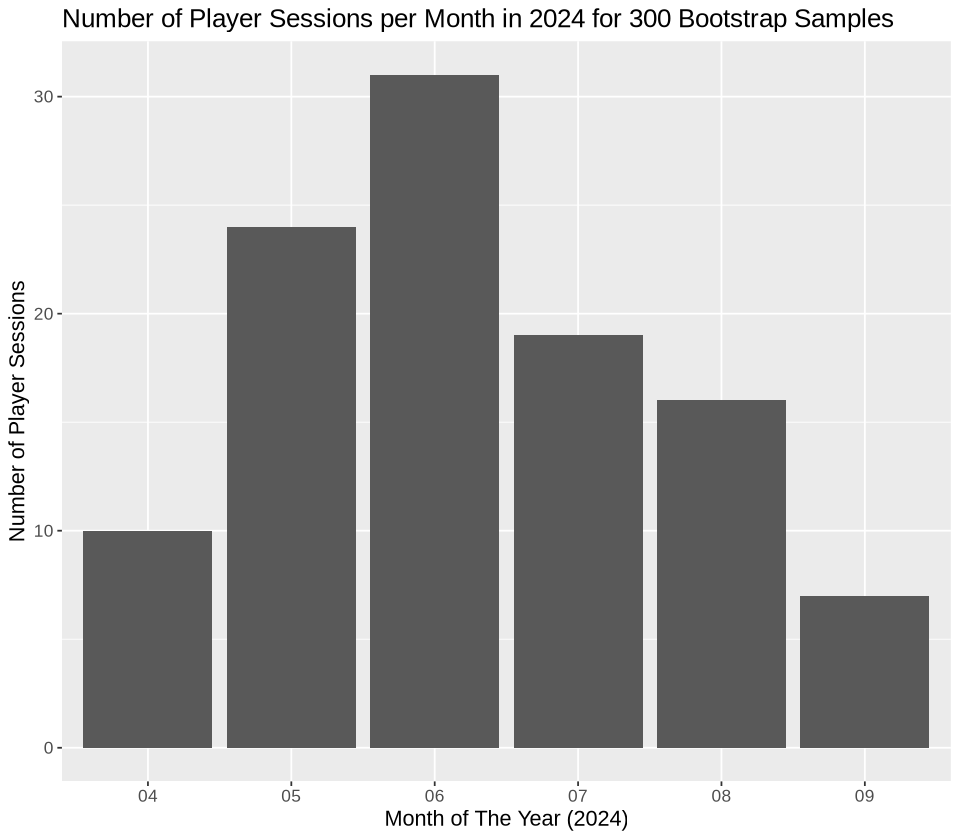

In [95]:
options(repr.plot.width = 8, repr.plot.height = 7)

sessions_plot <- sessions_month_average |>
    ggplot(aes(x = month, y = count)) + 
    geom_col() + 
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))
sessions_plot

We also see that May has a relative large number of player sessions, as such we should increase number of licenses on hand to sufficiently accommodate all parallel players with high probability.